In [1]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

print(gpu_info)

import tensorflow as tf
print(tf.test.is_built_with_cuda())

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Mon Dec 07 20:33:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 432.00       Driver Version: 432.00       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 206... WDDM  | 00000000:08:00.0  On |                  N/A |
|  0%   39C    P8    16W / 175W |    584MiB /  8192MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [17]:
import nibabel as nib
from scipy import ndimage
import os
from nilearn.image import resample_img

def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    min = -1000
    max = 40
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 145
    desired_width = 121
    desired_height = 121
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def resize(img):
    img = img.reshape(-1, 128,128,1)
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_img(volume)
    return volume

In [18]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "D:/CN/", x)
    for x in os.listdir("D:/CN/")
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "D:/AD/", x)
    for x in os.listdir("D:/AD/")
]

print("Normal control scans with normal brain tissue: " + str(len(normal_scan_paths)))
print("Alzheimer's scans with abnormal brain tissue: " + str(len(abnormal_scan_paths)))


Normal control scans with normal brain tissue: 100
Alzheimer's scans with abnormal brain tissue: 100


In [19]:
normal_scan_paths

['D:/CN/wmADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319113623975_S13408_I45108.nii',
 'D:/CN/wmADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001114742166_S13893_I118673.nii',
 'D:/CN/wmADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319115331858_S13893_I45117.nii',
 'D:/CN/wmADNI_002_S_0559_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001115028407_S14875_I118676.nii',
 'D:/CN/wmADNI_002_S_0559_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070216234409231_S14875_I40674.nii',
 'D:/CN/wmADNI_002_S_0685_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070216235850690_S16309_I40683.nii',
 'D:/CN/wmADNI_002_S_1261_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070727130404463_S26574_I62377.nii',
 'D:/CN/wmADNI_002_S_1280_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070713123810416_S26453_I60056.nii',
 'D:/CN/wmADNI_003_S_0907_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070501171753634_S19728_I52781.n

In [20]:
import numpy as np

abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

NameError: name 'resize_img' is not defined

In [21]:
import numpy as np

x_train = np.concatenate((abnormal_scans[15:], normal_scans[15:]))
y_train = np.concatenate((abnormal_labels[15:], normal_labels[15:]))
x_val = np.concatenate((abnormal_scans[:15], normal_scans[:15]))
y_val = np.concatenate((abnormal_labels[:15], normal_labels[:15]))
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 170 and 30.


In [22]:
x_train.shape

(170, 121, 145, 121)

In [23]:
import random

from scipy import ndimage

def train_preprocessing(volume, label):
    volume = tensorflow.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    volume = tensorflow.expand_dims(volume, axis=3)
    return volume, label

In [24]:
import os
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Conv2D, MaxPool2D, BatchNormalization, Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import pandas as pd
from tensorflow.keras import backend

train_loader = tensorflow.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tensorflow.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the MRI scan is: (121, 145, 121, 1)


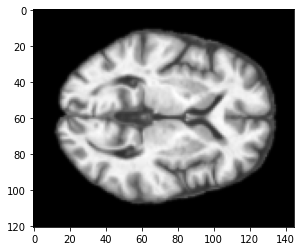

In [25]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 50]), cmap="gray")

In [26]:
def plot_slices(num_rows, num_columns, width, height, image_data):
    image_data = np.rot90(np.array(image_data))
    image_data = np.transpose(image_data)
    image_data = np.reshape(image_data, (num_rows, num_columns, width, height))
    rows_data, columns_data = image_data.shape[0], image_data.shape[1]
    heights = [slc[0].shape[0] for slc in image_data]
    widths = [slc.shape[1] for slc in image_data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(image_data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

plot_slices(5, 20, 121, 121, image[:, :, :100])

ValueError: cannot reshape array of size 1754500 into shape (5,20,121,121)

In [75]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Conv2D, MaxPool2D, BatchNormalization, Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

def get_model(width=121, height=121, depth=145):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, depth, height, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dense(units=128, activation='relu')(x)
    outputs = layers.Dense(units=1, activation='sigmoid')(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=121, height=121, depth=145)
epochs = 100
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate= 0.96 , staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)
model.summary()


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 121, 145, 121, 1) 0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 119, 143, 119, 64) 1792      
_________________________________________________________________
max_pooling3d_62 (MaxPooling (None, 59, 71, 59, 64)    0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 59, 71, 59, 64)    256       
_________________________________________________________________
conv3d_63 (Conv3D)           (None, 57, 69, 57, 64)    110656    
_________________________________________________________________
max_pooling3d_63 (MaxPooling (None, 28, 34, 28, 64)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 34, 28, 64)    256   

In [76]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "classification.h5", save_best_only=True
)

model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    batch_size = 32,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb],
)

Epoch 1/100
85/85 [==============================] - 20s 232ms/step - loss: 1.8730 - acc: 0.5294 - val_loss: 0.6932 - val_acc: 0.5000

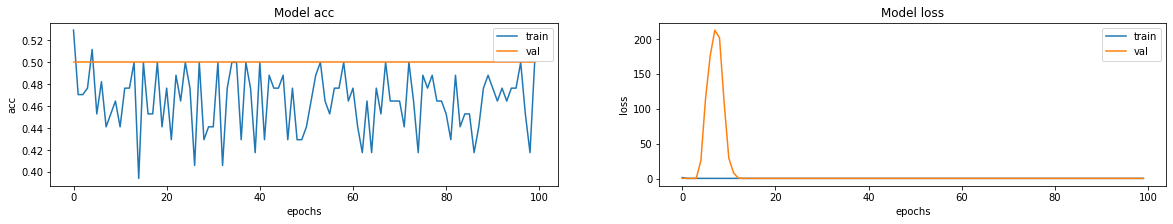

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [78]:
# Load best weights.
model.load_weights("classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((100 * score), name)
    )

This model is 50.00 percent confident that MRI scan is normal
This model is 50.00 percent confident that MRI scan is abnormal
